In [12]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load data
gold_df = pd.read_csv("gold-dataset-sinha-khandait.csv")
headlines_data = gold_df["News"].dropna().astype(str).tolist()

# Download resources
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /home/arko/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/arko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words])

processed_headlines = [preprocess(h) for h in headlines_data]

In [14]:
# Embedding with SentenceTransformers
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(processed_headlines)

In [15]:
# Clustering with DBSCAN using cosine distance
clustering = DBSCAN(eps=0.3, min_samples=3, metric="cosine")
labels = clustering.fit_predict(embeddings)

In [16]:
# Attach cluster labels to the DataFrame
gold_df = gold_df.loc[gold_df["News"].notna()].copy()
gold_df["cluster"] = labels


In [17]:
# Print sample clusters
for cluster_id in set(labels):
    print(f"\nCluster {cluster_id}:")
    sample = gold_df[gold_df["cluster"] == cluster_id]["News"].head(3).tolist()
    for headline in sample:
        print(" -", headline)


Cluster 0:
 - april gold down 20 cents to settle at $1,116.10/oz
 - gold suffers third straight daily decline
 - Gold futures edge up after two-session decline

Cluster 1:
 - gold declines first time in seven days after greek elections
 - gold inches up as markets await greek vote
 - gold trims advance on greek vote

Cluster 2:
 - gold survives goldman sachs
 - reuters : analysts slash gold price forecasts after second quarter plunge
 - goldman sachs cuts gold outlook, sees growing risk

Cluster 3:
 - moody's revises pilgrim's pride outlook on gold kist bid
 - gold kist rejects pilgrim's pride offer as inadequate
 - pilgrim's pride to acquire gold kist for $21 a share

Cluster 4:
 - us mint : sales of us mint american eagle gold, silver coins fall in march
 - us mint feb gold coins sales hit lowest in more than a decade
 - us mint : april lackluster for gold and silver eagles

Cluster 5:
 - eldorado gold downgraded to neutral from outperform at credit suisse
 - Alamos Gold downgraded 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


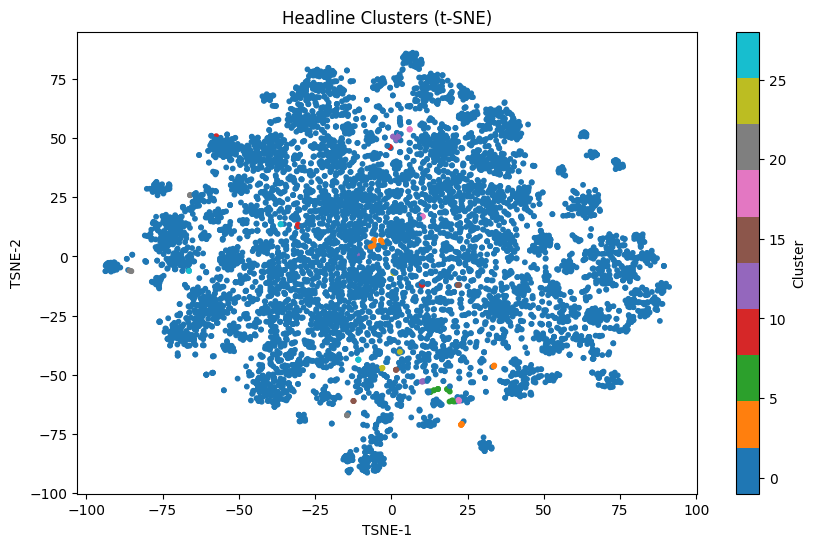

In [18]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap="tab10", s=10)
plt.title("Headline Clusters (t-SNE)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.colorbar(label="Cluster")
plt.show()